# Part One:

In [22]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

STATION_ID = "USC00087205"  # Plant City, FL
START = "1991-01-01"
END   = "2020-12-31"


In [23]:
# I actually just started using parquet files at work, what do ya know!
fp = f"s3://noaa-ghcn-pds/parquet/by_station/STATION={STATION_ID}/"

df = pd.read_parquet(
    fp,
    storage_options={"anon": True},
)

df.head(), df.shape

(            ID      DATE  DATA_VALUE M_FLAG Q_FLAG S_FLAG OBS_TIME ELEMENT
 0  USC00087205  19491226           2   None   None      0     None    DAPR
 1  USC00087205  19501208           2   None   None      0     None    DAPR
 2  USC00087205  19501218           2   None   None      0     None    DAPR
 3  USC00087205  19600911           2   None   None      0     None    DAPR
 4  USC00087205  19710708           3   None   None      0     None    DAPR,
 (224247, 8))

In [24]:
if np.issubdtype(df["DATE"].dtype, np.number):
    df["DATE"] = pd.to_datetime(df["DATE"].astype(str), format="%Y%m%d")
else:
    df["DATE"] = pd.to_datetime(df["DATE"])

df = df.sort_values("DATE").set_index("DATE")

tmin = df[df["ELEMENT"] == "TMIN"].copy()

tmin["tmin_C"] = tmin["DATA_VALUE"] / 10.0
tmin["tmin_F"] = (tmin["tmin_C"] * 9/5) + 32

tmin = tmin.loc[(tmin.index >= START) & (tmin.index <= END)]

tmin[["tmin_C", "tmin_F"]].describe()

,tmin_C,tmin_F
count,10682.000000,10682.00000
mean,17.065784,62.71841
std,6.197445,11.15540
min,-7.800000,17.96000
25%,13.300000,55.94000
50%,18.300000,64.94000
75%,22.200000,71.96000
max,32.200000,89.96000


In [25]:
tmin["frost_day"]  = (tmin["tmin_F"] <= 32.0).astype(int)
tmin["freeze_day"] = (tmin["tmin_F"] <= 28.0).astype(int)

monthly = (
    tmin
    .groupby([tmin.index.year.rename("year"), tmin.index.month.rename("month")])[["frost_day", "freeze_day"]]
    .sum()
    .reset_index()
)

monthly.head()


,year,month,frost_day,freeze_day
0,1991,1,0,0
1,1991,2,2,0
2,1991,3,0,0
3,1991,4,0,0
4,1991,5,0,0


In [26]:
# Months of interest: Oct(10), Nov(11), Dec(12), Jan(1)
months_target = [10, 11, 12, 1]

monthly_target = monthly[monthly["month"].isin(months_target)].copy()

climo = (
    monthly_target
    .groupby("month")[["frost_day", "freeze_day"]]
    .mean()
    .rename(columns={
        "frost_day": "mean_frost_days_per_month_(TMIN<=32F)",
        "freeze_day": "mean_freeze_days_per_month_(TMIN<=28F)"
    })
)

month_order = [10, 11, 12, 1]
climo = climo.reindex(month_order)

month_names = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
climo.insert(0, "month_name", [month_names[m] for m in climo.index])
climo


,month_name,mean_frost_days_per_month_(TMIN<=32F),mean_freeze_days_per_month_(TMIN<=28F)
month,,,
10,Oct,0.000000,0.000000
11,Nov,0.033333,0.000000
12,Dec,0.600000,0.166667
1,Jan,1.866667,0.500000


In [27]:
climo_rounded = climo.copy()
for c in climo_rounded.columns:
    if c != "month_name":
        climo_rounded[c] = climo_rounded[c].round(2)

climo_rounded


,month_name,mean_frost_days_per_month_(TMIN<=32F),mean_freeze_days_per_month_(TMIN<=28F)
month,,,
10,Oct,0.00,0.00
11,Nov,0.03,0.00
12,Dec,0.60,0.17
1,Jan,1.87,0.50


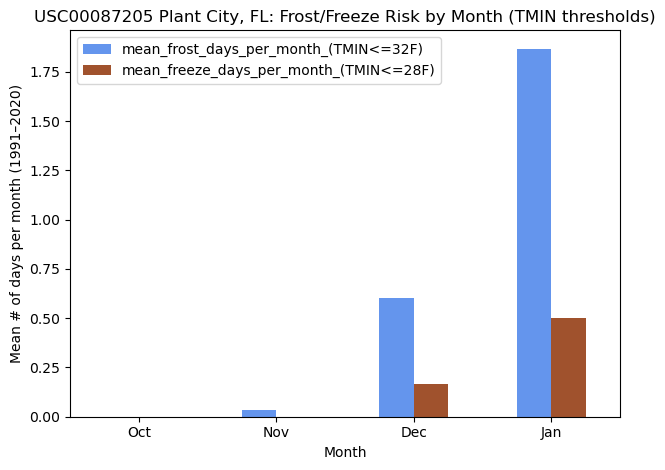

In [36]:
plot_df = climo.reset_index().copy()
plot_df["month_label"] = plot_df["month"].map({10:"Oct",11:"Nov",12:"Dec",1:"Jan"})
plot_df = plot_df.set_index("month_label")

ax = plot_df[["mean_frost_days_per_month_(TMIN<=32F)", "mean_freeze_days_per_month_(TMIN<=28F)"]].plot(kind="bar", color=["cornflowerblue", "sienna"])
ax.set_ylabel("Mean # of days per month (1991–2020)")
ax.set_xlabel("Month")
ax.set_title(f"{STATION_ID} Plant City, FL: Frost/Freeze Risk by Month (TMIN thresholds)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [29]:
obs_counts = (
    tmin["tmin_F"]
    .groupby([tmin.index.year.rename("year"), tmin.index.month.rename("month")])
    .count()
    .reset_index(name="n_obs_days")
)

obs_target = obs_counts[obs_counts["month"].isin([10,11,12,1])].copy()

obs_summary = (
    obs_target
    .groupby("month")["n_obs_days"]
    .describe()[["count","mean","min","max"]]
    .round(1)
)

obs_summary.index = [month_names[m] for m in obs_summary.index]
obs_summary


,count,mean,min,max
Jan,30.0,30.7,26.0,31.0
Oct,30.0,30.4,27.0,31.0
Nov,30.0,29.2,27.0,30.0
Dec,30.0,30.3,25.0,31.0


#### <span style="color: cornflowerblue;">Results:</span>
Monthly mean risk:
| Month | Mean frost days/month | Mean freeze days/month |
|-------|-----------------------|------------------------|
| Oct | 0 | 0 |
| Nov | 0.03 | 0 |
| Dec | 0.60 | 0.17 |
| Jan | 1.87 | 0.50 |


<span style="color: cornflowerblue; font-weight: bold;">October:</span> <span style="color: cornflowerblue;">No climatological frost or freeze risk. Strawberries will be essentially frost-free barring rare meteorological conditions that span beyond historical data.  </span>  
<span style="color: cornflowerblue; font-weight: bold;">November:</span> <span style="color: cornflowerblue;"> Frost is rare; freezes are effectively nonexistent.  </span>  
<span style="color: cornflowerblue; font-weight: bold;">December:</span> <span style="color: cornflowerblue;"> Frost risk becomes non-negligible, averaging about 0.6 frost days per month, with occasional freezes (about 1 freeze every six years).  </span>  
<span style="color: cornflowerblue; font-weight: bold;">January:</span> <span style="color: cornflowerblue;"> This is the highest risk month, wiht about 0.5 freeze days per month (a freeze every other year).  </span>
<span style="color: cornflowerblue; font-weight: bold;">Data Quality:</span> <span style="color: cornflowerblue;"> Monthly averages are based on 29-31 daily observations per month throughout 1991-2020, indicating excellent data completeness and high confidence in the climatological estimates!!</span>

# Part Two

In [30]:
freeze_monthly = (
    tmin["freeze_day"]
    .groupby([tmin.index.year.rename("year"), tmin.index.month.rename("month")])
    .sum()
    .reset_index()
)

freeze_monthly["date"] = pd.to_datetime(
    freeze_monthly["year"].astype(str) + "-" + freeze_monthly["month"].astype(str).str.zfill(2) + "-01"
)

freeze_monthly = freeze_monthly.set_index("date").sort_index()

freeze_monthly.head()


,year,month,freeze_day
date,,,
1991-01-01,1991,1,0
1991-02-01,1991,2,0
1991-03-01,1991,3,0
1991-04-01,1991,4,0
1991-05-01,1991,5,0


In [31]:
url = "https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices"

enso = pd.read_csv(
    url,
    sep=r"\s+",
    engine="python"
)

enso.head(), enso.columns

(     YR  MON  NINO1+2  ANOM  NINO3  ANOM.1  NINO4  ANOM.2  NINO3.4  ANOM.3
 0  1982    1    24.28 -0.24  25.84    0.17  28.01   -0.21    26.65    0.08
 1  1982    2    25.38 -0.72  26.26   -0.11  27.99   -0.11    26.54   -0.20
 2  1982    3    25.22 -1.38  26.92   -0.25  28.18   -0.05    27.09   -0.14
 3  1982    4    24.57 -1.16  27.52   -0.05  28.61    0.10    27.83    0.02
 4  1982    5    24.00 -0.62  27.70    0.49  29.19    0.40    28.37    0.49,
 Index(['YR', 'MON', 'NINO1+2', 'ANOM', 'NINO3', 'ANOM.1', 'NINO4', 'ANOM.2',
        'NINO3.4', 'ANOM.3'],
       dtype='object'))

In [32]:
enso_anom = enso.rename(columns={"YR": "year", "MON": "month"}).copy()

anom_map = {
    "NINO1+2": "ANOM",
    "NINO3": "ANOM.1",
    "NINO4": "ANOM.2",
    "NINO3.4": "ANOM.3"
}

enso_anom = enso_anom[["year", "month"] + list(anom_map.values())].copy()
enso_anom = enso_anom.rename(columns={v: k for k, v in anom_map.items()})

enso_anom["date"] = pd.to_datetime(
    enso_anom["year"].astype(int).astype(str) + "-" +
    enso_anom["month"].astype(int).astype(str).str.zfill(2) + "-01"
)
enso_anom = enso_anom.set_index("date").sort_index()

for c in ["NINO1+2", "NINO3", "NINO4", "NINO3.4"]:
    enso_anom[c] = pd.to_numeric(enso_anom[c], errors="coerce")

enso_anom = enso_anom.loc["1991-01-01":"2020-12-31"]

enso_anom.head()


,year,month,NINO1+2,NINO3,NINO4,NINO3.4
date,,,,,,
1991-01-01,1991,1,-0.78,-0.05,0.40,0.33
1991-02-01,1991,2,-0.40,-0.10,0.30,0.14
1991-03-01,1991,3,-0.28,-0.20,0.15,-0.08
1991-04-01,1991,4,-0.52,-0.19,0.22,0.08
1991-05-01,1991,5,0.04,0.22,0.39,0.25


In [33]:
joined = freeze_monthly[["freeze_day"]].join(
    enso_anom[["NINO1+2", "NINO3", "NINO4", "NINO3.4"]],
    how="inner"
)

cold_months = [11, 12, 1, 2, 3]  # Nov–Mar
joined_cold = joined[joined.index.month.isin(cold_months)].copy()

results = []
y = joined_cold["freeze_day"]

for c in ["NINO1+2", "NINO3", "NINO4", "NINO3.4"]:
    r = y.corr(joined_cold[c])  # Pearson correlation
    results.append({"index": c, "pearson_r": r, "abs_r": abs(r)})

corr_df = pd.DataFrame(results).sort_values("abs_r", ascending=False).reset_index(drop=True)
corr_df

best = corr_df.iloc[0]
print(f"Best-correlated ENSO index with monthly freeze days (<28°F): {best['index']}")
print(f"Pearson r = {best['pearson_r']:.3f} (|r| = {best['abs_r']:.3f})")



Best-correlated ENSO index with monthly freeze days (<28°F): NINO1+2
Pearson r = -0.143 (|r| = 0.143)


#### </span> <span style="color: cornflowerblue;">Results:</span>
</span> <span style="color: cornflowerblue;">Among the ENSO SST forcing regions examined, the NINO1+2 index shows the strongest (though weak) relationship with freeze occurrence in central Florida, exhibiting the highest absolute Pearson correlation with monthly freeze-day counts.</span>